In [3]:
# evaluate.ipynb

import gymnasium as gym
import highway_env
import pandas as pd
import numpy as np
import os
from datetime import datetime

from stable_baselines3 import PPO, DQN, SAC

# --- SELECT AGENT HERE ---
AGENT_TYPE = "dqn"   # "ppo", "dqn", "sac", "random"

AGENT_DIR = {
    "ppo": "ppo_agent",
    "dqn": "dqn_agent",
    "sac": "sac_agent",
}.get(AGENT_TYPE, None)

N_EPISODES = 20
SAFE_TTC_THRESHOLD = 2.0
MAX_STEPS_PER_EPISODE = 200

if AGENT_TYPE != "random":
    if AGENT_TYPE == "ppo":
        model = PPO.load(f"{AGENT_DIR}/model")
    elif AGENT_TYPE == "dqn":
        model = DQN.load(f"{AGENT_DIR}/model")
    elif AGENT_TYPE == "sac":
        model = SAC.load(f"{AGENT_DIR}/model")
else:
    model = None

# Prepare result folders
os.makedirs(f"{AGENT_DIR}/instant_runs", exist_ok=True) if AGENT_DIR else None
os.makedirs(f"{AGENT_DIR}/summary", exist_ok=True) if AGENT_DIR else None

# Evaluation environment
env = gym.make("highway-v0", render_mode="human")
env.unwrapped.config["vehicles_count"] = 5
env.unwrapped.config["duration"] = MAX_STEPS_PER_EPISODE
env.unwrapped.config["policy_frequency"] = 1

all_episode_stats = []

print(f"\n=== Evaluating {AGENT_TYPE.upper()} agent ===")

for ep in range(N_EPISODES):
    obs, info = env.reset()
    done = truncated = False

    ep_reward = 0
    ep_steps = 0
    ep_speed_sum = 0
    ep_lane_changes = 0

    previous_speed = 0.0
    previous_acc = 0.0
    jerk_values = []
    ttc_values = []

    while not (done or truncated):
        if AGENT_TYPE == "random":
            action = env.action_space.sample()
        else:
            action, _ = model.predict(obs, deterministic=True)

        obs, reward, done, truncated, info = env.step(action)
        ep_reward += reward
        ep_steps += 1

        # Speed
        ego_speed = obs[0][3]
        ep_speed_sum += ego_speed

        # Jerk
        acc = ego_speed - previous_speed
        jerk = acc - previous_acc
        jerk_values.append(abs(jerk))
        previous_speed = ego_speed
        previous_acc = acc

        # TTC
        min_ttc = float("inf")
        ego_x, ego_y = obs[0][1], obs[0][2]

        for idx in range(1, len(obs)):
            if obs[idx][0] == 0:
                continue

            rel_x = obs[idx][1] - ego_x
            rel_y = abs(obs[idx][2] - ego_y)

            if rel_x > 0 and rel_y < 0.2:
                rel_v = ego_speed - obs[idx][3]
                if rel_v > 0.01:
                    ttc = rel_x / rel_v
                    min_ttc = min(min_ttc, ttc)

        if min_ttc != float("inf"):
            ttc_values.append(min_ttc)

        # Lane changes
        if action in [0, 2]:
            ep_lane_changes += 1

    # Episode stats
    avg_speed = ep_speed_sum / (ep_steps + 1e-6)
    avg_jerk = np.mean(jerk_values)
    max_jerk = np.max(jerk_values)
    avg_ttc = np.mean(ttc_values) if ttc_values else -1
    min_ttc = np.min(ttc_values) if ttc_values else -1
    ttc_violations = sum(t < SAFE_TTC_THRESHOLD for t in ttc_values)
    ttc_violation_rate = ttc_violations / (ep_steps + 1e-6)

    all_episode_stats.append({
        "episode": ep+1,
        "total_reward": ep_reward,
        "steps": ep_steps,
        "avg_speed_ms": avg_speed,
        "lane_changes": ep_lane_changes,
        "avg_jerk": avg_jerk,
        "max_jerk": max_jerk,
        "avg_ttc": avg_ttc,
        "min_ttc": min_ttc,
        "ttc_violation_rate": ttc_violation_rate,
        "collision": info.get("crashed", False),
        "success": not info.get("crashed", False) and not truncated
    })

    print(f"Episode {ep+1}/{N_EPISODES} complete")

env.close()

# Save results
df = pd.DataFrame(all_episode_stats)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

df.to_csv(f"{AGENT_DIR}/instant_runs/run_{timestamp}.csv", index=False)
df.mean(numeric_only=True).to_frame("Value").to_csv(
    f"{AGENT_DIR}/summary/summary_{timestamp}.csv"
)

print("\n✔ Evaluation complete!")



=== Evaluating DQN agent ===
Episode 1/20 complete
Episode 2/20 complete
Episode 3/20 complete
Episode 4/20 complete
Episode 5/20 complete
Episode 6/20 complete
Episode 7/20 complete
Episode 8/20 complete
Episode 9/20 complete
Episode 10/20 complete
Episode 11/20 complete
Episode 12/20 complete
Episode 13/20 complete
Episode 14/20 complete
Episode 15/20 complete
Episode 16/20 complete
Episode 17/20 complete
Episode 18/20 complete
Episode 19/20 complete
Episode 20/20 complete

✔ Evaluation complete!


---

## 📊 PART 2: Performance Indicators Calculation

Now we calculate the 5 key performance indicators defined in README.md Section 7-8:

1. **Safety Index (SI)** - Combines collision rate, TTC, and violations
2. **Efficiency Index (EI)** - Speed and success rate
3. **Comfort Index (CI)** - Smoothness (inverse of jerk and lane changes)
4. **Rule Compliance Index (RCI)** - Traffic rule adherence
5. **Global Performance Score (GPS)** - Weighted aggregate of all indices

### Indicator Weights (from research priorities):
- GPS = **40% Safety** + **30% Efficiency** + **15% Comfort** + **15% Compliance**

In [6]:
# ============================================================================
# UPDATED INDICATOR CALCULATION MODULE (MATCHES evaluate.ipynb OUTPUT)
# ============================================================================

# Constants for normalization
SPEED_LIMIT_MS = 32.0       # m/s, matches highway-env reward_speed_range max
SAFE_TTC_THRESHOLD = 2.0    # seconds, safe time-to-collision threshold

# Rename evaluate-ipynb metrics → indicator-friendly names
final_metrics = {
    "Collision Rate": float(df["collision"].mean()),
    "Success Rate": float(df["success"].mean()),
    "Average Speed (m/s)": float(df["avg_speed_ms"].mean()),
    "Avg Jerk (Comfort)": float(df["avg_jerk"].mean()),
    "Avg Lane Changes / Episode": float(df["lane_changes"].mean()),
    "Avg Time-to-Collision (s)": float(df["avg_ttc"].mean()),
    "Min Time-to-Collision (s)": float(df["min_ttc"].mean()),
    "TTC Violation Rate": float(df["ttc_violation_rate"].mean()),
    "Speed Limit Compliance": float(min(df["avg_speed_ms"].mean() / SPEED_LIMIT_MS, 1.0))
}

# ---------------------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------------------

INDICATOR_WEIGHTS = {
    "safety_index": {
        "w_collision": 0.4,
        "w_ttc": 0.4,
        "w_ttc_violations": 0.2
    },
    "efficiency_index": {
        "w_speed": 0.5,
        "w_success": 0.5
    },
    "comfort_index": {
        "w_jerk": 0.6,
        "w_lane_changes": 0.4
    },
    "rule_compliance_index": {
        "w_speed_compliance": 1.0
    },
    "global_performance": {
        "a_safety": 0.40,
        "b_efficiency": 0.30,
        "c_comfort": 0.15,
        "d_compliance": 0.15
    }
}

MAX_EXPECTED_JERK = 10.0
MAX_EXPECTED_LANE_CHANGES = 20.0

# ---------------------------------------------------------------------------
# HELPERS
# ---------------------------------------------------------------------------

def get_metric_value(metrics_dict, metric_name, default=0.0):
    return metrics_dict.get(metric_name, default)

# ---------------------------------------------------------------------------
# SAFETY INDEX
# ---------------------------------------------------------------------------

def calculate_safety_index(metrics):
    w = INDICATOR_WEIGHTS["safety_index"]

    collision_rate = get_metric_value(metrics, "Collision Rate")
    avg_ttc = get_metric_value(metrics, "Avg Time-to-Collision (s)", -1)
    ttc_violation_rate = get_metric_value(metrics, "TTC Violation Rate")

    # TTC normalized (higher = safer)
    if avg_ttc > 0:
        ttc_normalized = min(avg_ttc / SAFE_TTC_THRESHOLD, 1.0)
    else:
        ttc_normalized = 0.0

    return (
        w["w_collision"] * (1 - collision_rate) +
        w["w_ttc"] * ttc_normalized +
        w["w_ttc_violations"] * (1 - ttc_violation_rate)
    )

# ---------------------------------------------------------------------------
# EFFICIENCY INDEX
# ---------------------------------------------------------------------------

def calculate_efficiency_index(metrics):
    w = INDICATOR_WEIGHTS["efficiency_index"]

    avg_speed = get_metric_value(metrics, "Average Speed (m/s)")
    success_rate = get_metric_value(metrics, "Success Rate")

    speed_ratio = min(avg_speed / SPEED_LIMIT_MS, 1.0)

    return (
        w["w_speed"] * speed_ratio +
        w["w_success"] * success_rate
    )

# ---------------------------------------------------------------------------
# COMFORT INDEX
# ---------------------------------------------------------------------------

def calculate_comfort_index(metrics):
    w = INDICATOR_WEIGHTS["comfort_index"]

    jerk = get_metric_value(metrics, "Avg Jerk (Comfort)")
    lane_changes = get_metric_value(metrics, "Avg Lane Changes / Episode")

    jerk_norm = min(jerk / MAX_EXPECTED_JERK, 1.0)
    lane_norm = min(lane_changes / MAX_EXPECTED_LANE_CHANGES, 1.0)

    discomfort = (
        w["w_jerk"] * jerk_norm +
        w["w_lane_changes"] * lane_norm
    )

    return max(1 - discomfort, 0.0)

# ---------------------------------------------------------------------------
# RULE COMPLIANCE INDEX
# ---------------------------------------------------------------------------

def calculate_rule_compliance_index(metrics):
    return get_metric_value(metrics, "Speed Limit Compliance")

# ---------------------------------------------------------------------------
# GLOBAL PERFORMANCE SCORE
# ---------------------------------------------------------------------------

def calculate_global_performance_score(si, ei, ci, rci):
    w = INDICATOR_WEIGHTS["global_performance"]

    return (
        w["a_safety"] * si +
        w["b_efficiency"] * ei +
        w["c_comfort"] * ci +
        w["d_compliance"] * rci
    )

# ---------------------------------------------------------------------------
# CALCULATE ALL INDICATORS
# ---------------------------------------------------------------------------

SI = calculate_safety_index(final_metrics)
EI = calculate_efficiency_index(final_metrics)
CI = calculate_comfort_index(final_metrics)
RCI = calculate_rule_compliance_index(final_metrics)
GPS = calculate_global_performance_score(SI, EI, CI, RCI)

indicators = {
    "Safety Index (SI)": SI,
    "Efficiency Index (EI)": EI,
    "Comfort Index (CI)": CI,
    "Rule Compliance Index (RCI)": RCI,
    "Global Performance Score (GPS)": GPS
}

print("\n=== PERFORMANCE INDICATORS ===")
for k, v in indicators.items():
    print(f"{k:<30} : {v:.4f}")



=== PERFORMANCE INDICATORS ===
Safety Index (SI)              : 0.2200
Efficiency Index (EI)          : 0.0054
Comfort Index (CI)             : 0.9245
Rule Compliance Index (RCI)    : 0.0108
Global Performance Score (GPS) : 0.2299


---

## 📈 PART 3: Visualization (Optional)

Uncomment and run the cell below to create a visual comparison chart of all indicators.

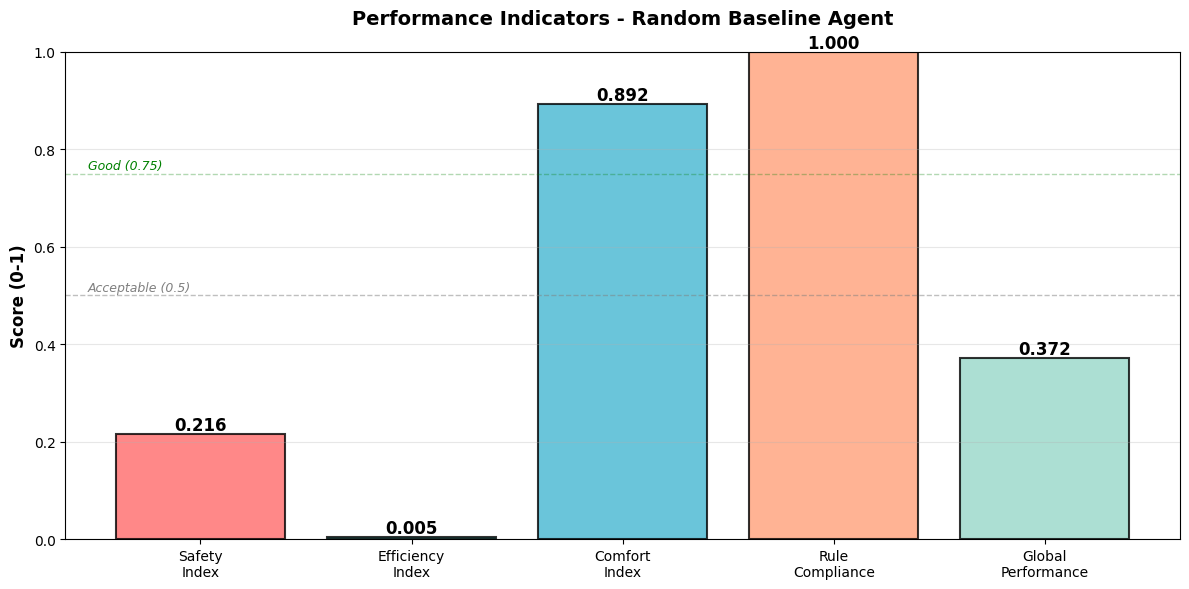


📊 Visualization complete!


In [5]:
# ============================================================================
# VISUALIZATION: Bar Chart of Indicators
# ============================================================================
# Uncomment the code below to create a visual chart

import matplotlib.pyplot as plt

# Prepare data for plotting
indicator_names = ['Safety\nIndex', 'Efficiency\nIndex', 'Comfort\nIndex', 
                   'Rule\nCompliance', 'Global\nPerformance']
indicator_values = [SI, EI, CI, RCI, GPS]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(indicator_names, indicator_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, value in zip(bars, indicator_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.3f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Styling
ax.set_ylim(0, 1.0)
ax.set_ylabel('Score (0-1)', fontsize=12, fontweight='bold')
ax.set_title('Performance Indicators - Random Baseline Agent', fontsize=14, fontweight='bold', pad=20)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(y=0.75, color='green', linestyle='--', alpha=0.3, linewidth=1)
ax.grid(axis='y', alpha=0.3)

# Add reference lines legend
ax.text(0.02, 0.51, 'Acceptable (0.5)', transform=ax.transAxes, 
        fontsize=9, color='gray', style='italic')
ax.text(0.02, 0.76, 'Good (0.75)', transform=ax.transAxes, 
        fontsize=9, color='green', style='italic')

plt.tight_layout()
plt.show()

print("\n📊 Visualization complete!")

---

## 🏆 PART 4: Multi-Model Comparison (Optional)

**After running multiple models**, use the cell below to compare them all side-by-side.

This replaces the need for the separate `analyze_results.py` script!

In [6]:
# ============================================================================
# MULTI-MODEL COMPARISON
# ============================================================================
# Run this cell AFTER you've completed all model runs (Random, PPO, DQN, SAC)
# to generate a side-by-side comparison table

import glob

# --- Configuration ---
MODELS_TO_COMPARE = [
    ("Random Baseline", "random_baseline_agent/summary/summary_*.csv"),
    ("PPO Agent", "ppo_agent/summary/summary_*.csv"),
    ("DQN Agent", "dqn_agent/summary/summary_*.csv"),
    ("SAC Agent", "sac_agent/summary/summary_*.csv"),
]

# Enable comparison mode
RUN_COMPARISON = False  # Set to True when you want to compare models

if RUN_COMPARISON:
    print("\n" + "="*70)
    print("🏆 MULTI-MODEL COMPARISON")
    print("="*70)
    
    comparison_results = []
    
    for model_name, csv_pattern in MODELS_TO_COMPARE:
        # Find the most recent CSV for this model
        csv_files = glob.glob(csv_pattern)
        
        if not csv_files:
            print(f"\n⚠️  No data found for {model_name} (pattern: {csv_pattern})")
            continue
        
        # Get the most recent file
        latest_csv = max(csv_files, key=os.path.getctime)
        
        print(f"\n📊 Loading {model_name} from: {os.path.basename(latest_csv)}")
        
        # Load metrics
        model_metrics_df = pd.read_csv(latest_csv)
        model_metrics = dict(zip(model_metrics_df['Metric'], model_metrics_df['Value']))
        
        # Calculate indicators for this model
        model_SI = calculate_safety_index(model_metrics)
        model_EI = calculate_efficiency_index(model_metrics)
        model_CI = calculate_comfort_index(model_metrics)
        model_RCI = calculate_rule_compliance_index(model_metrics)
        model_GPS = calculate_global_performance_score(model_SI, model_EI, model_CI, model_RCI)
        
        # Store results
        comparison_results.append({
            'Model': model_name,
            'Safety_Index': model_SI,
            'Efficiency_Index': model_EI,
            'Comfort_Index': model_CI,
            'Rule_Compliance_Index': model_RCI,
            'Global_Performance_Score': model_GPS,
            'Collision_Rate': get_metric_value(model_metrics, "Collision Rate"),
            'Success_Rate': get_metric_value(model_metrics, "Success Rate"),
            'Avg_Speed': get_metric_value(model_metrics, "Average Speed (m/s)"),
            'Avg_Reward': get_metric_value(model_metrics, "Average Reward / Episode")
        })
    
    if comparison_results:
        # Create comparison DataFrame
        comparison_df = pd.DataFrame(comparison_results)
        
        # Display comparison table
        print("\n" + "="*70)
        print("📊 PERFORMANCE COMPARISON TABLE")
        print("="*70)
        print("\n--- Key Indicators ---")
        print(comparison_df[['Model', 'Global_Performance_Score', 'Safety_Index', 
                             'Efficiency_Index', 'Comfort_Index', 'Rule_Compliance_Index']].to_string(index=False))
        
        print("\n--- Raw Metrics ---")
        print(comparison_df[['Model', 'Collision_Rate', 'Success_Rate', 
                             'Avg_Speed', 'Avg_Reward']].to_string(index=False))
        
        print("="*70)
        
        # Highlight best performers
        print("\n🥇 BEST PERFORMERS:")
        print("-" * 70)
        
        best_performers = {
            'Global Performance': comparison_df.loc[comparison_df['Global_Performance_Score'].idxmax()],
            'Safety': comparison_df.loc[comparison_df['Safety_Index'].idxmax()],
            'Efficiency': comparison_df.loc[comparison_df['Efficiency_Index'].idxmax()],
            'Comfort': comparison_df.loc[comparison_df['Comfort_Index'].idxmax()],
            'Compliance': comparison_df.loc[comparison_df['Rule_Compliance_Index'].idxmax()],
        }
        
        for category, best_model in best_performers.items():
            if category == 'Global Performance':
                score = best_model['Global_Performance_Score']
                metric = 'GPS'
            elif category == 'Safety':
                score = best_model['Safety_Index']
                metric = 'SI'
            elif category == 'Efficiency':
                score = best_model['Efficiency_Index']
                metric = 'EI'
            elif category == 'Comfort':
                score = best_model['Comfort_Index']
                metric = 'CI'
            else:
                score = best_model['Rule_Compliance_Index']
                metric = 'RCI'
            
            print(f"   {category:<20}: {best_model['Model']:<20} ({metric} = {score:.4f})")
        
        print("="*70)
        
        # Save comparison results
        comparison_output_dir = "model_comparison"
        os.makedirs(comparison_output_dir, exist_ok=True)
        comparison_output_path = os.path.join(comparison_output_dir, 
                                              f"comparison_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
        comparison_df.to_csv(comparison_output_path, index=False)
        print(f"\n✅ Comparison results saved to: {comparison_output_path}")
        
        # Optional: Create comparison visualization
        try:
            import matplotlib.pyplot as plt
            
            # Prepare data for grouped bar chart
            models = comparison_df['Model'].tolist()
            x = np.arange(len(models))
            width = 0.15
            
            fig, ax = plt.subplots(figsize=(14, 7))
            
            # Plot bars for each indicator
            bars1 = ax.bar(x - 2*width, comparison_df['Safety_Index'], width, label='Safety', color='#FF6B6B', alpha=0.8)
            bars2 = ax.bar(x - width, comparison_df['Efficiency_Index'], width, label='Efficiency', color='#4ECDC4', alpha=0.8)
            bars3 = ax.bar(x, comparison_df['Comfort_Index'], width, label='Comfort', color='#45B7D1', alpha=0.8)
            bars4 = ax.bar(x + width, comparison_df['Rule_Compliance_Index'], width, label='Compliance', color='#FFA07A', alpha=0.8)
            bars5 = ax.bar(x + 2*width, comparison_df['Global_Performance_Score'], width, label='GPS', color='#98D8C8', alpha=0.8, edgecolor='black', linewidth=2)
            
            # Styling
            ax.set_ylabel('Score (0-1)', fontsize=12, fontweight='bold')
            ax.set_title('Multi-Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
            ax.set_xticks(x)
            ax.set_xticklabels(models, fontsize=11)
            ax.legend(loc='upper left', fontsize=10)
            ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
            ax.axhline(y=0.75, color='green', linestyle='--', alpha=0.3, linewidth=1)
            ax.set_ylim(0, 1.0)
            ax.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print("\n📊 Comparison visualization complete!")
            
        except Exception as e:
            print(f"\n⚠️  Could not create visualization: {e}")
    
    else:
        print("\n❌ No model data found. Make sure you've run simulations for at least one model.")
        print("   Expected directory structure:")
        for model_name, csv_pattern in MODELS_TO_COMPARE:
            print(f"   - {csv_pattern}")

else:
    print("\n💡 TIP: To compare multiple models:")
    print("   1. Run this notebook for each model (Random, PPO, DQN, SAC)")
    print("   2. Set RUN_COMPARISON = True in this cell")
    print("   3. Re-run this cell to see side-by-side comparison!")
    print("\n   This replaces the need for analyze_results.py 🎯")


💡 TIP: To compare multiple models:
   1. Run this notebook for each model (Random, PPO, DQN, SAC)
   2. Set RUN_COMPARISON = True in this cell
   3. Re-run this cell to see side-by-side comparison!

   This replaces the need for analyze_results.py 🎯
